In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [3]:
import zipfile
import os

zip_path = r"C:\Users\admin\Desktop\SEM 5\DL\chip_data.zip"  
extract_path = r"C:\Users\admin\Desktop\SEM 5\DL\data"       

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")
print(os.listdir(extract_path)) 


Extraction complete!
['dataset', 'MNIST']


In [4]:
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [5]:
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

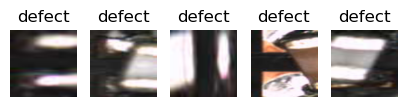

In [6]:
show_sample_images(train_dataset)

In [7]:
print(f"Total number of training samples: {len(train_dataset)}")

first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [8]:
print(f"Total testing samples: {len(test_dataset)}")
first_image_test, label_test = test_dataset[0]
print(f"Shape of first test image: {first_image_test.shape}")

Total testing samples: 121
Shape of first test image: torch.Size([3, 224, 224])


In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
from torchvision import models

model = models.vgg19(pretrained=True)

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [13]:
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
for param in model.features.parameters():
    param.requires_grad = False  

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

In [18]:
def train_model(model, train_loader,test_loader,num_epochs=10):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    print("Name: Priyanka K")
    print("Register Number: 212223230162")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


Epoch [1/10], Train Loss: 0.6132, Validation Loss: 0.4118
Epoch [2/10], Train Loss: 0.3839, Validation Loss: 0.3154
Epoch [3/10], Train Loss: 0.2978, Validation Loss: 0.2768
Epoch [4/10], Train Loss: 0.2762, Validation Loss: 0.2477
Epoch [5/10], Train Loss: 0.2261, Validation Loss: 0.2290
Epoch [6/10], Train Loss: 0.2046, Validation Loss: 0.2222
Epoch [7/10], Train Loss: 0.1730, Validation Loss: 0.2131
Epoch [8/10], Train Loss: 0.1543, Validation Loss: 0.2070
Epoch [9/10], Train Loss: 0.1621, Validation Loss: 0.2011
Epoch [10/10], Train Loss: 0.1494, Validation Loss: 0.1997
Name: Priyanka K
Register Number: 212223230162


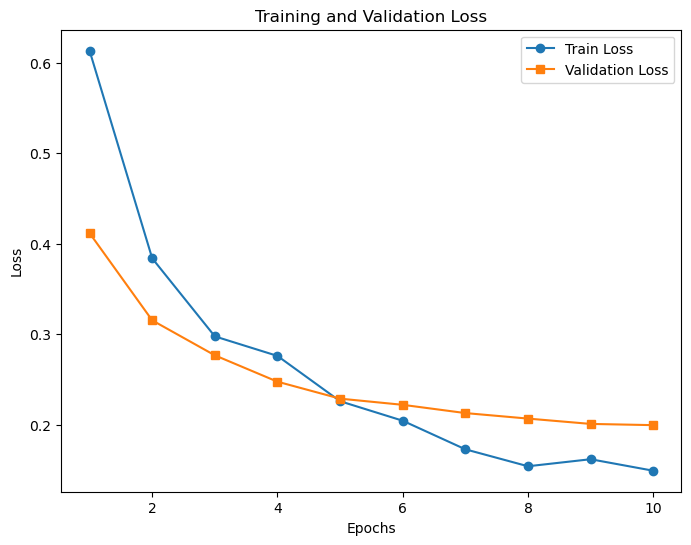

In [19]:
train_model(model, train_loader, test_loader, num_epochs=10)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    cm = confusion_matrix(all_labels, all_preds)
    print("Name: Priyanka K")
    print("Register Number: 212223230162")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("Name: Priyanka K")
    print("Register Number: 212223230162")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


Test Accuracy: 0.9256
Name: Priyanka K
Register Number: 212223230162


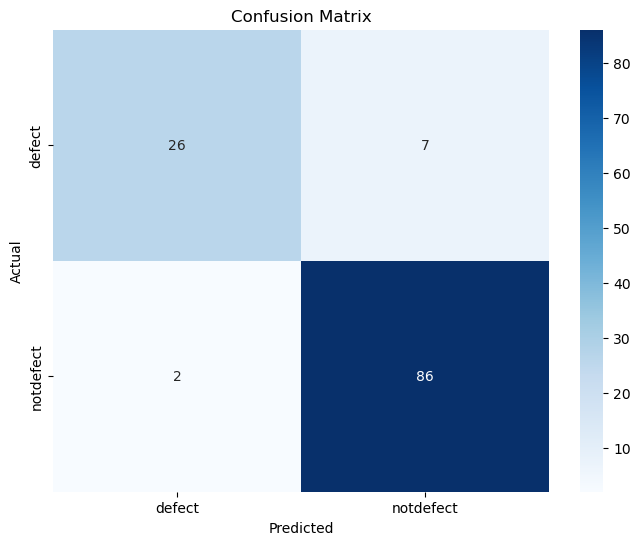

Name: Priyanka K
Register Number: 212223230162
Classification Report:
              precision    recall  f1-score   support

      defect       0.93      0.79      0.85        33
   notdefect       0.92      0.98      0.95        88

    accuracy                           0.93       121
   macro avg       0.93      0.88      0.90       121
weighted avg       0.93      0.93      0.92       121



In [22]:
test_model(model, test_loader)

In [23]:
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)  
        output = model(image_tensor)

        prob = torch.softmax(output, dim=1)
        predicted = torch.argmax(prob, dim=1).item() 

    class_names = dataset.classes
    image_to_display = transforms.ToPILImage()(image)
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f"Actual: {class_names[label]}\nPredicted: {class_names[predicted]}")
    plt.axis("off")
    plt.show()

    print(f"Actual: {class_names[label]}, Predicted: {class_names[predicted]}")

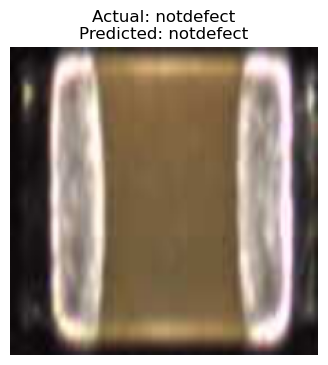

Actual: notdefect, Predicted: notdefect


In [24]:
predict_image(model, image_index=55, dataset=test_dataset)

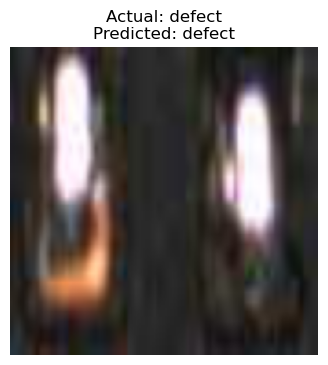

Actual: defect, Predicted: defect


In [25]:
predict_image(model, image_index=25, dataset=test_dataset)